# Estación Barajas Pueblo

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [4]:
df = pd.read_csv("../data/df_27.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,NO2
month,
2013-01-01,43.258065
2013-02-01,32.354839
2013-03-01,26.612903
2013-04-01,22.322581
2013-05-01,21.870968


### Estacionalidad

In [6]:
df2 = df.copy()

In [7]:
df2["año"] = df.index.year
df2["mes"] = df.index.month

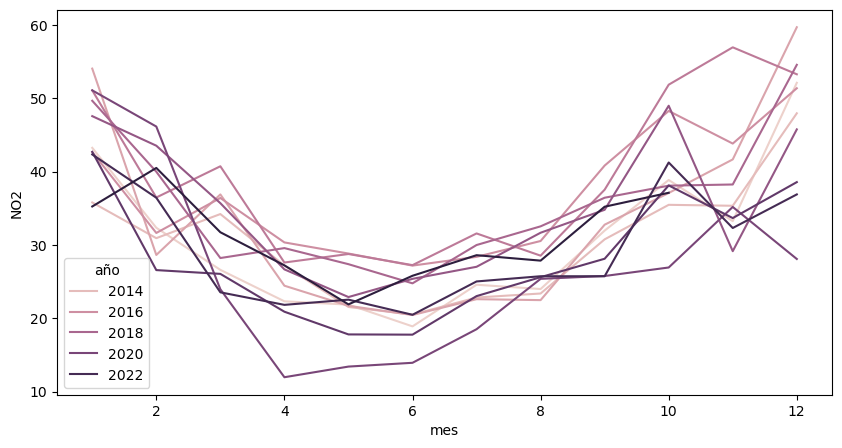

In [8]:
sns.lineplot(x = "mes", y = "NO2", hue = "año", data = df2);

### Estacionaridad

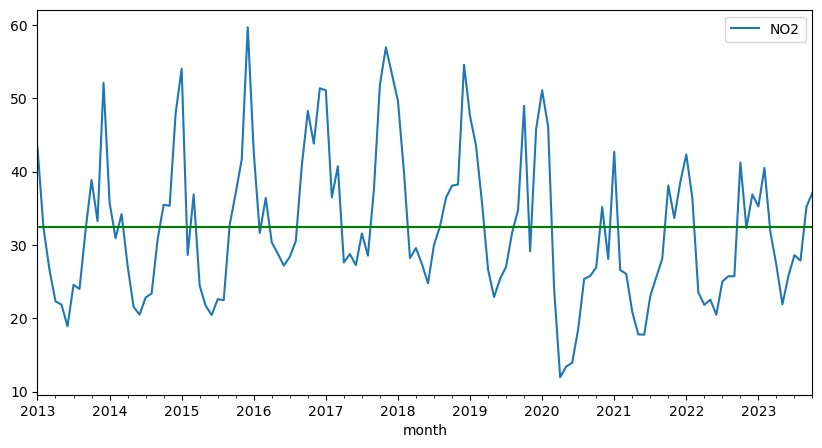

In [9]:
df.plot()
plt.axhline(df.NO2.mean(), c = "g");

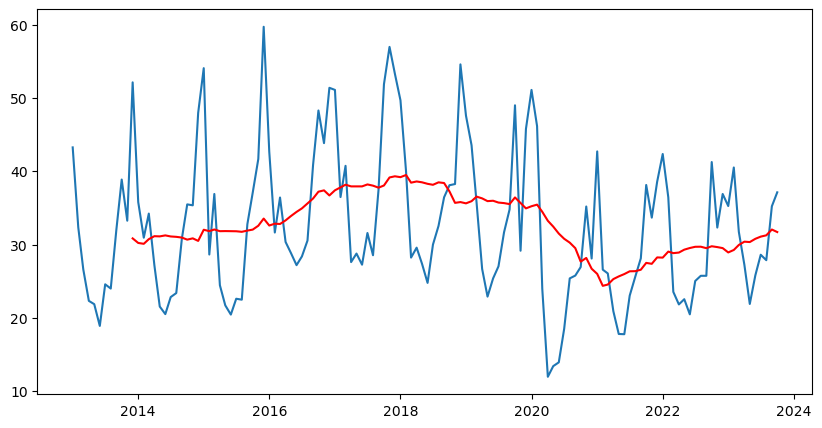

In [10]:
plt.plot(df["NO2"])
plt.plot(df.rolling(window= 12).mean(), c = "r");

### Test de Fuller

In [11]:
res = adfuller(df["NO2"])
res

(-1.2723268612887753,
 0.6417358217234828,
 13,
 116,
 {'1%': -3.4880216384691867,
  '5%': -2.8867966864160075,
  '10%': -2.5802408234244947},
 748.8665047490613)

In [12]:
print("AD Fuller Stats", res[0])
print("p-value", res[1])
print("Critical values")

for k, v in res[4].items():
    print(k, round(v, 2))

AD Fuller Stats -1.2723268612887753
p-value 0.6417358217234828
Critical values
1% -3.49
5% -2.89
10% -2.58


*Datos no estacionarios. Su media y su varianza están en función del tiempo 🍋*

### Autocorrelación

In [13]:
for i in range(49):
    print(f"{i} mes Lag, {df['NO2'].autocorr(lag= i)}")

0 mes Lag, 1.0
1 mes Lag, 0.6760219554315088
2 mes Lag, 0.42878583061716335
3 mes Lag, 0.12743031206446595
4 mes Lag, -0.19209953482726644
5 mes Lag, -0.4030629809702153
6 mes Lag, -0.46456941804142143
7 mes Lag, -0.41317397965137576
8 mes Lag, -0.21210996500220355
9 mes Lag, 0.11336770188546437
10 mes Lag, 0.38653204158612114
11 mes Lag, 0.6207266485132259
12 mes Lag, 0.7639808217321392
13 mes Lag, 0.6484287696507833
14 mes Lag, 0.3615970871936107
15 mes Lag, 0.08565131138436737
16 mes Lag, -0.2804621655009678
17 mes Lag, -0.4677415432851281
18 mes Lag, -0.5373059295713698
19 mes Lag, -0.4837767253054197
20 mes Lag, -0.27636287818707483
21 mes Lag, 0.050097055419818785
22 mes Lag, 0.29377912457774735
23 mes Lag, 0.5560652998167055
24 mes Lag, 0.6924990009629506
25 mes Lag, 0.5314713268841694
26 mes Lag, 0.29282288180217986
27 mes Lag, -0.00993637700991526
28 mes Lag, -0.34968392878959353
29 mes Lag, -0.5791132301277809
30 mes Lag, -0.6564564591226205
31 mes Lag, -0.5523824526448827
32

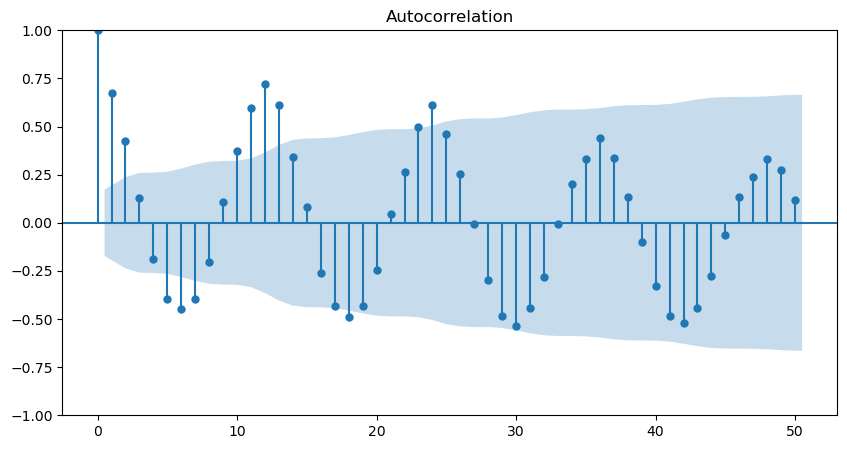

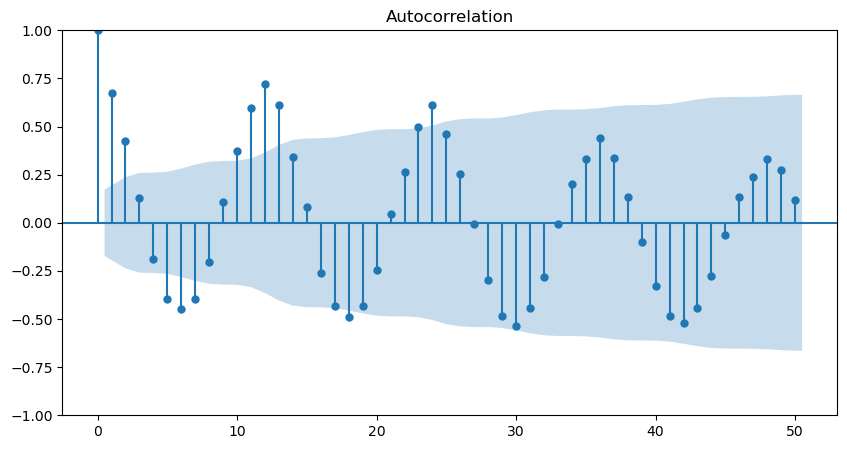

In [14]:
plot_acf(df, lags = 50)

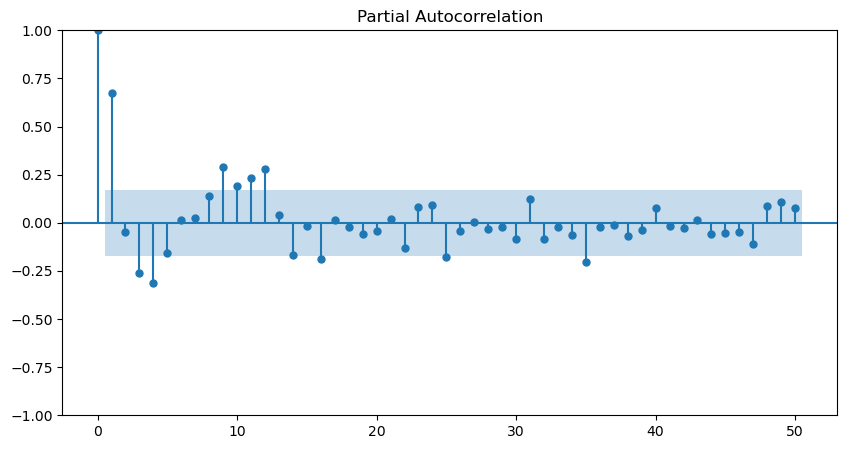

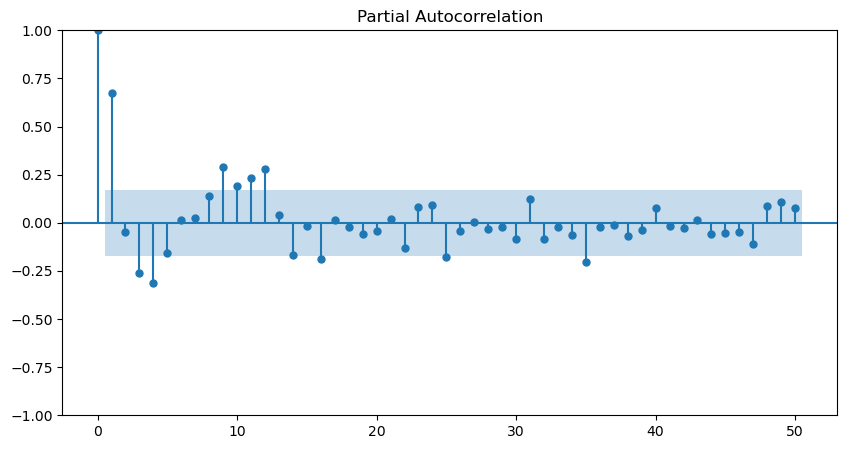

In [15]:
plot_pacf(df, lags = 50)

In [16]:
df.head()

,NO2
month,
2013-01-01,43.258065
2013-02-01,32.354839
2013-03-01,26.612903
2013-04-01,22.322581
2013-05-01,21.870968


In [17]:
df.shape

(130, 1)

In [18]:
df.isnull().sum()

NO2    0
dtype: int64

## SARIMA

In [19]:
y_test = df["NO2"][-30:]
y_train = df["NO2"][:-30]

In [20]:
ps = range(4)
ds = range(1,3)
qs = range(3)

parameters = list(product(ps,ds, qs))
print(parameters)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2)]


In [21]:
%%time

modelo=SARIMAX(endog=y_train, 
               exog=None,
               #order=(4, 1, 5),  # modelo arima
               seasonal_order=(4, 1, 3, 12) # modelo sarima, estacionalidad es el ultimo
              ).fit(disp=False)
                     
pred=modelo.predict(len(y_train), len(df)-1)  

error=(pred-y_test).abs().sum()/len(pred) 
print ('Error mae: ', error)


res=pd.DataFrame({'real':y_test, 'pred':pred, 'error':pred-y_test})
res

C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Error mae:  3.371188418862801
CPU times: total: 953 ms
Wall time: 6.82 s


,real,pred,error
2021-05-01,17.806452,18.634326,0.827874
2021-06-01,17.774194,19.660031,1.885838
2021-07-01,23.032258,21.880662,-1.151597
2021-08-01,25.612903,27.049795,1.436892
2021-09-01,28.129032,31.390660,3.261628
2021-10-01,38.129032,35.886374,-2.242659
2021-11-01,33.677419,30.405699,-3.271721
2021-12-01,38.580645,44.837935,6.257289
2022-01-01,42.354839,46.081083,3.726244
2022-02-01,36.451613,34.408573,-2.043040


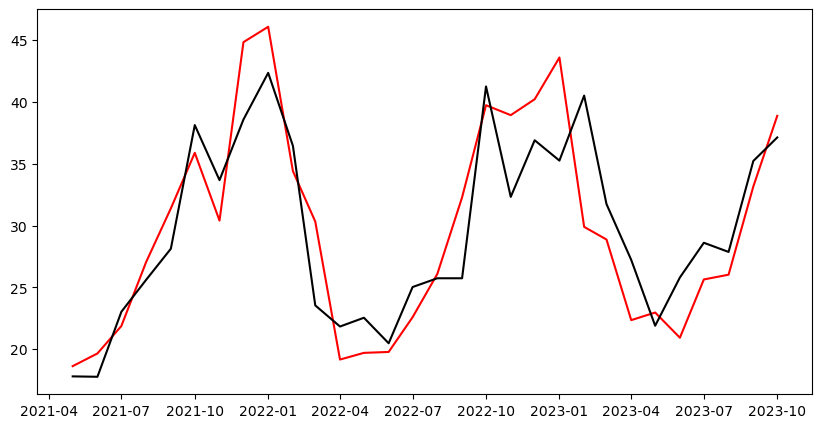

In [22]:
plt.plot(res["pred"], c = "r")
plt.plot(res["real"], c = "black");

In [23]:
pred_año = pd.DataFrame(modelo.predict(start = len(df), end = len(df) + 12))
pred_año

,predicted_mean
2023-11-01,44.264776
2023-12-01,47.000307
2024-01-01,44.297929
2024-02-01,31.083600
2024-03-01,32.568714
2024-04-01,28.393853
2024-05-01,25.490031
2024-06-01,23.958087
2024-07-01,27.553590
2024-08-01,27.887402


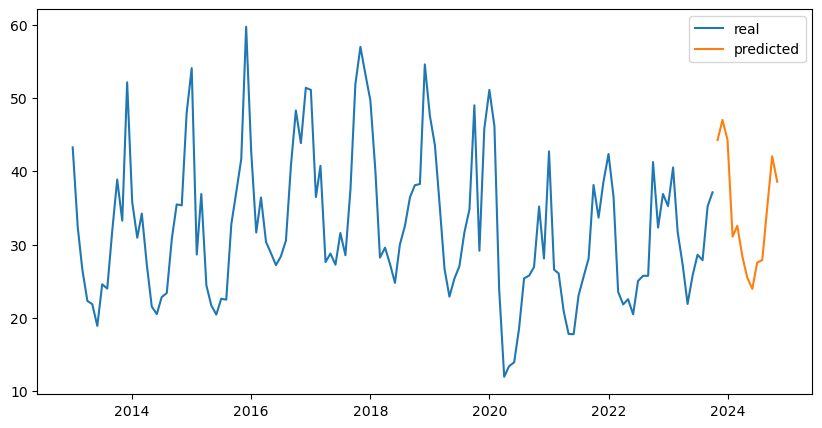

In [24]:
plt.plot(df)
plt.plot(pred_año)
plt.legend(["real", "predicted"]);

In [25]:
pred_año.mean()

predicted_mean    34.484616
dtype: float64